In [1]:
## environment solving
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

# tf.executing_eagerly()

''' the writer using
2.6.0
sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)
matplotlib 3.4.3
numpy 1.19.5
pandas 1.3.2
sklearn 0.24.2
tensorflow 2.6.0
keras.api._v2.keras 2.6.0
'''

2.6.0
sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)
matplotlib 3.4.3
numpy 1.19.5
pandas 1.3.2
sklearn 0.24.2
tensorflow 2.6.0
keras.api._v2.keras 2.6.0


" the writer using\n2.6.0\nsys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)\nmatplotlib 3.4.3\nnumpy 1.19.5\npandas 1.3.2\nsklearn 0.24.2\ntensorflow 2.6.0\nkeras.api._v2.keras 2.6.0\n"

In [2]:
# if use gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

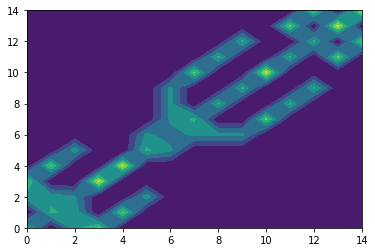

In [3]:
from AdjacencyGraph import AdjacencySolver
ad = AdjacencySolver(onehot=True,use_connect=False,use_flow = False,invert = False)
# for row in ad.A_init:
#     print(row)

# mesh a picture
x = range(15)
y = range(15)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, ad.A_init)
plt.show()

In [4]:
future_len = 60
past_len = 100

from Data_Loader import Data_Loader
from Scanner import Scanner

scanner = Scanner(train_len = 1,future_len = future_len,past_len = past_len)
min_len = scanner.len_of_frames

raw_data = Data_Loader(data_root='../datas/',min_len = min_len,equalize_clear_datalen = True,is_tolist = False)
print(raw_data.useful_sets)
print(raw_data.useful_attr)

loading imu data in ../datas/


e:\00Research\codes\00AAGC_LSTM\current_working\Data_Loader.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res[attr] = np.array([data for data in data[attr] if data.shape[0]>= self.min_len])


train_data
smpl_pose : 842 of [300, 135]
acceleration : 842 of [300, 15]
orientation : 842 of [300, 45]
test_data
smpl_pose : 18 of [5609, 135]
acceleration : 18 of [5609, 15]
orientation : 18 of [5609, 45]
val_data
smpl_pose : 3 of [6578, 135]
acceleration : 3 of [6578, 15]
orientation : 3 of [6578, 45]
All data checked, which lens are equal
['train_data', 'test_data', 'val_data']
['smpl_pose', 'acceleration', 'orientation', 'seq_lens']


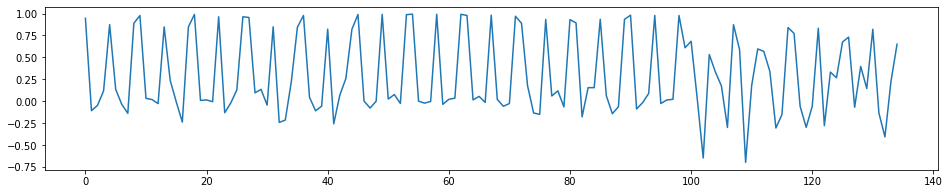

##Data_Processor## members: train_len, test_len, val_len ## train_data, test_data, val_data
##IMU_Dataset## reset dataset by : reset_xx() method, get batch data by : xx_batch() method


In [5]:
# padding seq_lens
from Data_Processor import Data_Processor
from IMU_Dataset import IMU_Dataset 

apply_mean = True
processed_data = Data_Processor(raw_data,apply_mean=apply_mean)
if apply_mean == True:
    mean_smpl = processed_data.mean_smpl
    plt.figure(num =1,figsize = [16,3])
    plt.plot(range(135),mean_smpl)
    plt.show()
processed_data.help()

imu_dataset = IMU_Dataset(processed_data,scanner,repeat = 15,shuffle_buffer = 10000,num_batch = 64)
imu_dataset.help()

In [6]:
# # for a continue seq of data, the trainning process may be continue too
acc_mask = np.arange(15)
ori_mask = np.arange(15,60)
smpl_mask = np.arange(60,195)
past_mask = np.arange(past_len)
future_mask =  np.arange(past_len,past_len + future_len)
def data_Spilt(datas):
    input_acc = datas[:,:,acc_mask]
    input_ori = datas[:,:,ori_mask]
    target_smpl = datas[:,:,smpl_mask]
    input_all = [input_acc[:,past_mask,:], input_ori[:,past_mask,:],
                np.flip(input_acc[:,future_mask,:], 1),np.flip(input_ori[:,future_mask,:], 1)]
    output = target_smpl[:,past_len,:]
    return input_all, output

In [7]:
# print(imu_dataset.train_batch().shape)
# print(imu_dataset.test_batch().shape)
# print(imu_dataset.val_batch().shape)
# ''' expected result
# (32, 100, 195)
# (32, 100, 195)
# (32, 100, 195)
# '''

In [8]:
import datetime
now_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S_')
model_prefix = "FIRST_"
model_path = "../models/"
model_name = "AAGC.weight"
model_name = model_prefix + now_time + model_name

In [9]:
# models aagc
from GraphLayer import AAGCLayer

input_acc_past = keras.layers.Input(shape=[past_len,15])
input_acc_future = keras.layers.Input(shape=[future_len,15])

h_acc_p =  keras.layers.Dense(20,activation = "sigmoid")(input_acc_past)
h_acc_f =  keras.layers.Dense(20,activation = "sigmoid")(input_acc_future)

input_ori_past = keras.layers.Input(shape=[past_len,45])
input_ori_future = keras.layers.Input(shape=[future_len,45])

h_ori_p =  keras.layers.Dense(40,activation = "sigmoid")(input_ori_past)
h_ori_f =  keras.layers.Dense(40,activation = "sigmoid")(input_ori_future)

cc_p = keras.layers.concatenate([h_acc_p,h_ori_p])
cc_f = keras.layers.concatenate([h_acc_f,h_ori_f])

h_p = keras.layers.LSTM(135,return_sequences=False,return_state=False)(cc_p)
h_f = keras.layers.LSTM(135,return_sequences=False,return_state=False)(cc_f)

ad = tf.add(h_p,h_f)

hidden_graph = AAGCLayer(15,15)(ad)
output = keras.layers.Dense(135,activation = "tanh")(hidden_graph)

# output = keras.layers.Dense(135,activation = "tanh")(ad)

aagc = keras.models.Model(inputs = [input_acc_past, input_ori_past, input_acc_future, input_ori_future],
                           outputs = [output])

# aagc.compile(loss="mean_absolute_error", optimizer="rmsprop")
# aagc.compile(loss="mean_squared_error", optimizer="rmsprop")
aagc.compile(loss="mean_squared_error", optimizer="Adam")

# callbacks = [keras.callbacks.EarlyStopping(
#     patience=5, min_delta=1e-5)]
aagc.summary()
# try:
#     for id,output in enumerate(outputs):
#         print(id," : ",output.shape)
# except TypeError:
#     print(outputs.shape)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 15)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100, 45)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60, 15)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 60, 45)]     0                                            
______________________________________________________________________________________________

In [10]:
# 记录过程值，以便最后可视化
train_loss_results = []
train_accuracy_results = []
train_val_results = []
train_test_results = []

num_epochs = 5000
show_step = 10

early_stopping = False
best_loss = 10000000.0
early_stopping_bearing = 8
num_no_improve = 0

for epoch in range(num_epochs):
    # traindata operation
    input_acc_ori, target_smpl = data_Spilt(imu_dataset.train_batch())
    # train one epoch
    loss_value = aagc.train_on_batch(input_acc_ori, target_smpl)

    # test one sets
    input_acc_ori, target_smpl = data_Spilt(imu_dataset.test_batch())
    test_loss = aagc.test_on_batch(input_acc_ori, target_smpl)
    imu_dataset.reset_test()
    imu_dataset.reset_train()

    # record datas
    train_loss_results.append(loss_value)
    train_test_results.append(test_loss)

    if epoch % show_step == 0:
        print("Epoch {} loss={} test_loss={}".format(epoch, loss_value, test_loss))

    if early_stopping:
        if test_loss < best_loss:
            best_loss = test_loss
            # TODO: still bug, maybe due to tf.Varaible serialize
            # TypeError: __init__() got an unexpected keyword argument 'name'
            # aagc.save(model_path + model_name)
            aagc.save_weights(model_path + model_name)
            num_no_improve = 0
        elif num_no_improve < early_stopping_bearing:
            num_no_improve += 1
        else:
            print("Early stopping in step : " + str(epoch) +" with best loss : "+ str(best_loss))
            break
if not early_stopping:
    # aagc.save(model_path + model_name)
    aagc.save_weights(model_path + model_name)

Epoch 0 loss=0.22373537719249725 test_loss=0.12241116166114807
Epoch 10 loss=0.0446307398378849 test_loss=0.038148730993270874
Epoch 20 loss=0.03922734782099724 test_loss=0.041662104427814484
Epoch 30 loss=0.04567544534802437 test_loss=0.040293604135513306
Epoch 40 loss=0.037388723343610764 test_loss=0.044645294547080994
Epoch 50 loss=0.040592603385448456 test_loss=0.045814331620931625
Epoch 60 loss=0.054477524012327194 test_loss=0.04293898120522499
Epoch 70 loss=0.03959294408559799 test_loss=0.04633659869432449
Epoch 80 loss=0.04346583038568497 test_loss=0.038864657282829285
Epoch 90 loss=0.03696146234869957 test_loss=0.03986825793981552
Epoch 100 loss=0.04411435127258301 test_loss=0.04144014045596123
Epoch 110 loss=0.03847573697566986 test_loss=0.03894336149096489
Epoch 120 loss=0.046061571687459946 test_loss=0.04024556651711464
Epoch 130 loss=0.04757584258913994 test_loss=0.04263152554631233
Epoch 140 loss=0.041449688374996185 test_loss=0.04396698623895645
Epoch 150 loss=0.034971632

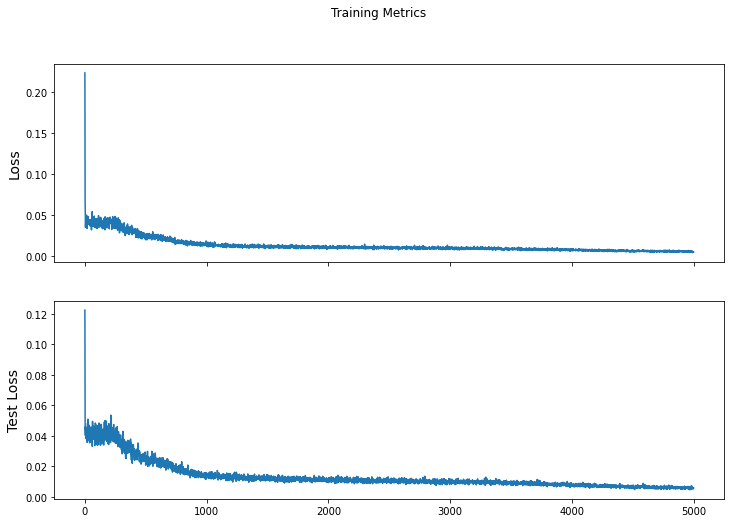

In [12]:
# 训练过程可视化
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Test Loss", fontsize=14)
axes[1].plot(train_test_results)

plt.show()

In [13]:
aagc_load = keras.models.Model(inputs = [input_acc_past, input_ori_past, input_acc_future, input_ori_future],
                           outputs = [output])
aagc_load.load_weights(model_path + model_name)
# aagc_load.load_weights('../models/good_ones/version_1_0_30000_epoch.weight')

(64, 160, 195)
max bias:  0.534380395126053
avg bias:  0.04741062883837147


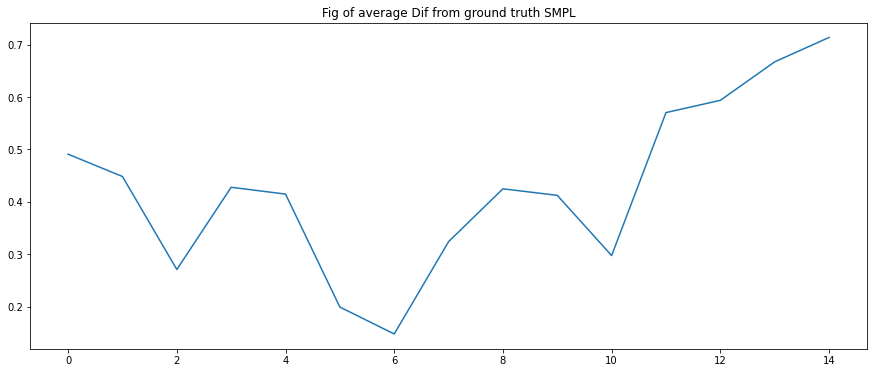

'\n这里可以发现不同位置，smpl预测数据的偏差值不同\n'

In [14]:
spml_index = range(135)
imu_dataset.reset_val()
# val_data = np.expand_dims(imu_dataset.val_batch()[0,:,:],axis = 0)
val_data = imu_dataset.val_batch()
print(val_data.shape)
x,y = data_Spilt(val_data)
_y = aagc_load(x)

print("max bias: ",np.max(np.abs(y- _y.numpy())))
print("avg bias: ",np.average(np.abs(y- _y.numpy())))

node = np.sum(np.abs(y- _y.numpy()).reshape(-1,15,9),axis = 2)
dif_mean = np.average(node,axis = 0).tolist()
plt.figure(figsize=[15,6])
plt.title("Fig of average Dif from ground truth SMPL")
plt.plot(spml_index[:15],dif_mean)
plt.show()
'''
这里可以发现不同位置，smpl预测数据的偏差值不同
'''

参照下图可以知道是不同节点的误差不同

![](./imgs/nodes.png)

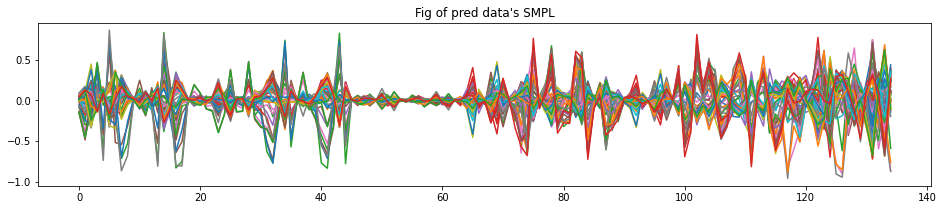

In [15]:
plt.figure(num = 20,figsize=[16,3])
for idx in range(y.shape[0]):

    pred_y = _y.numpy().tolist()[idx]

    plt.title("Fig of pred data's SMPL")
    plt.plot(spml_index,pred_y)

plt.show()

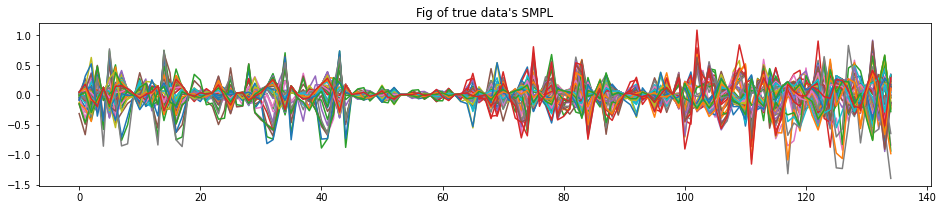

In [16]:
plt.figure(num = 20,figsize=[16,3])
for idx in range(y.shape[0]):

    true_y = y.tolist()[idx]

    plt.title("Fig of true data's SMPL")
    plt.plot(spml_index,true_y)

plt.show()

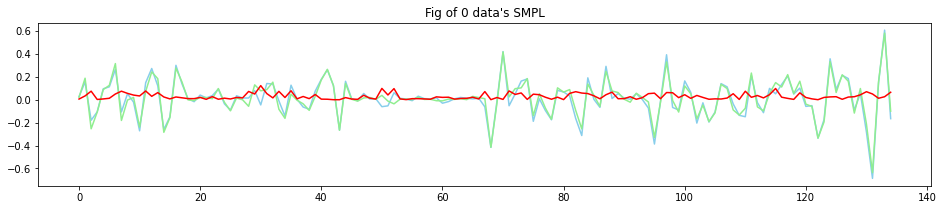

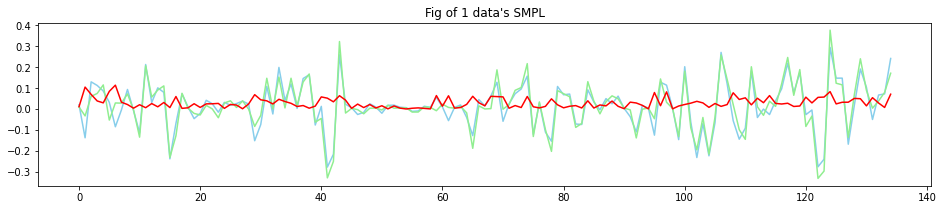

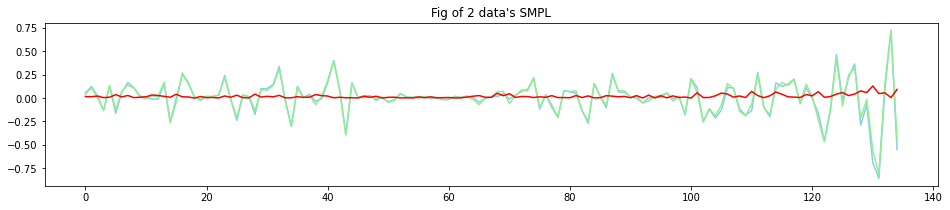

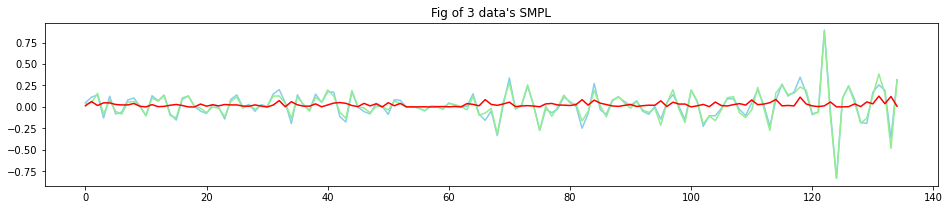

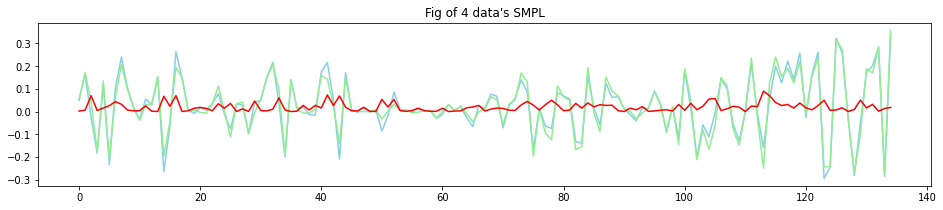

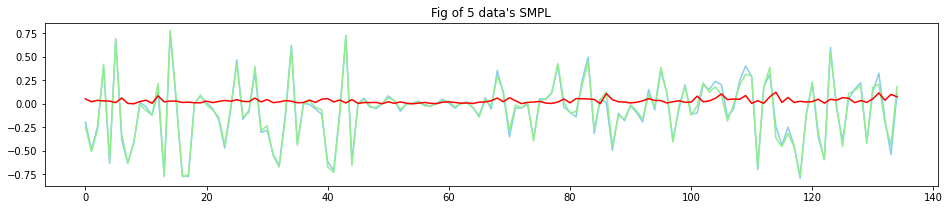

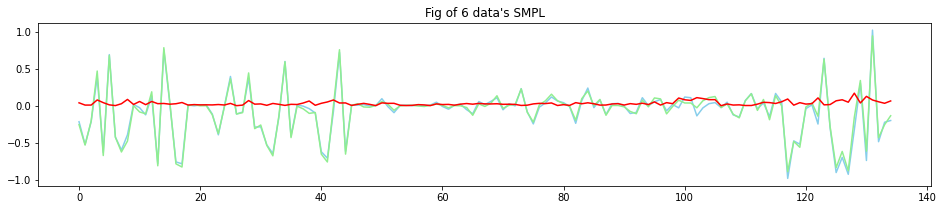

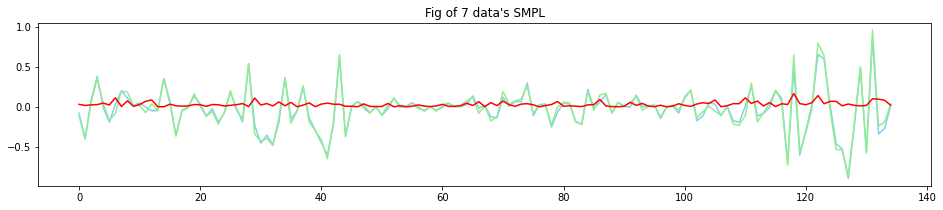

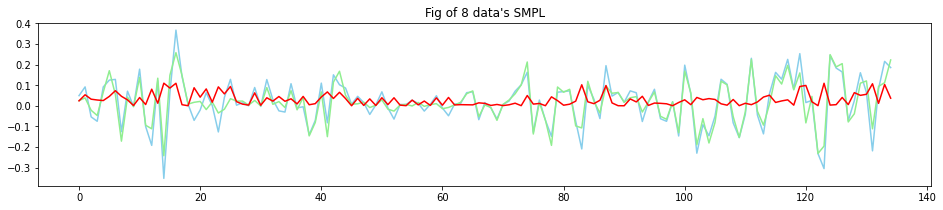

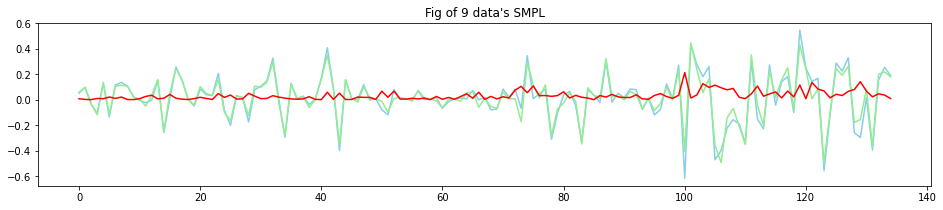

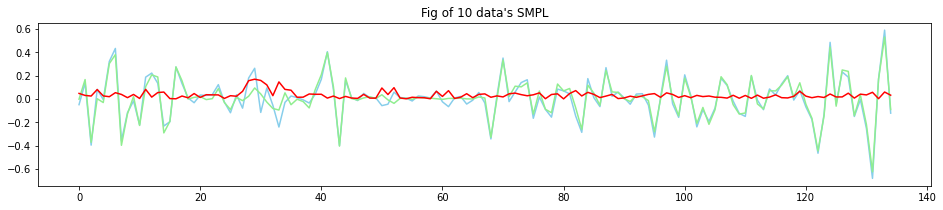

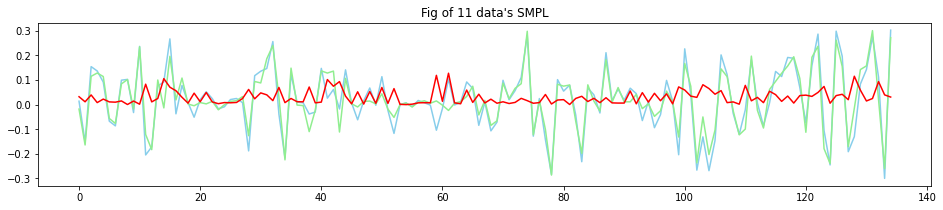

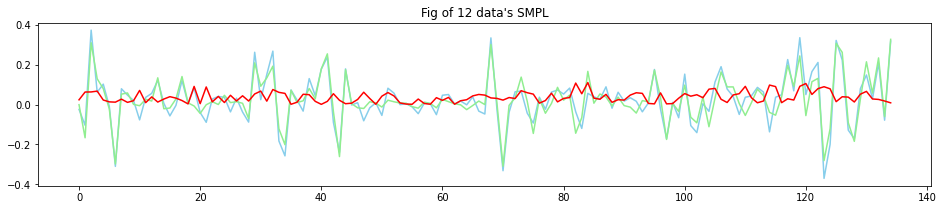

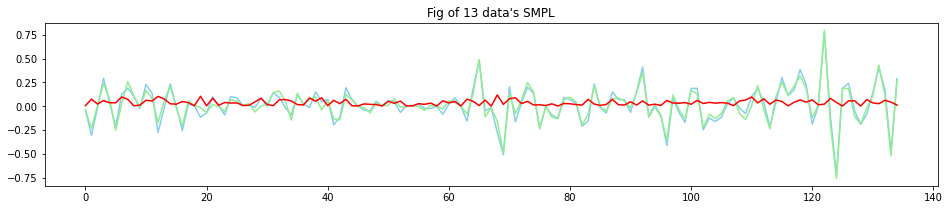

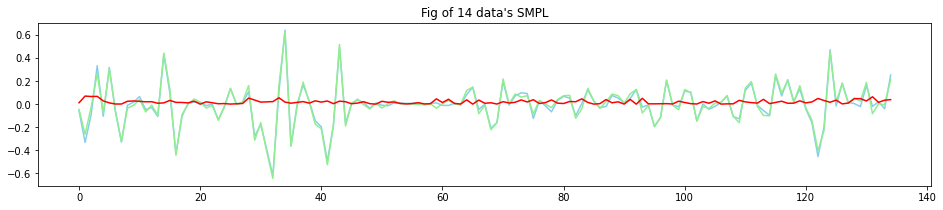

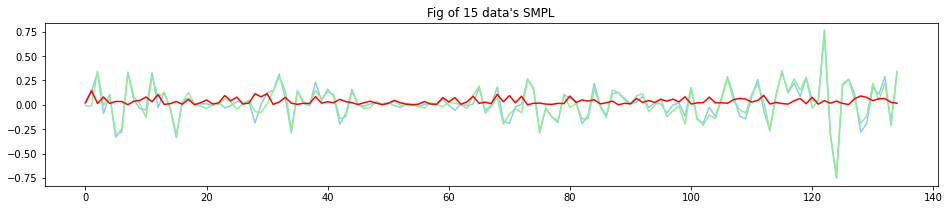

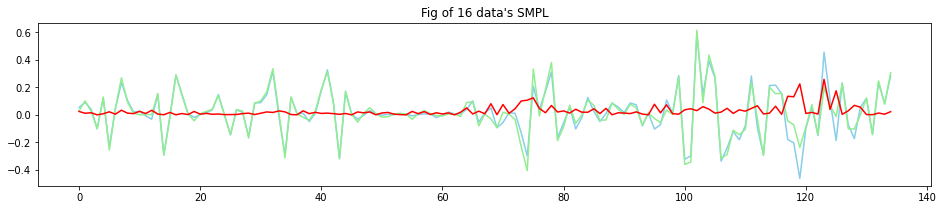

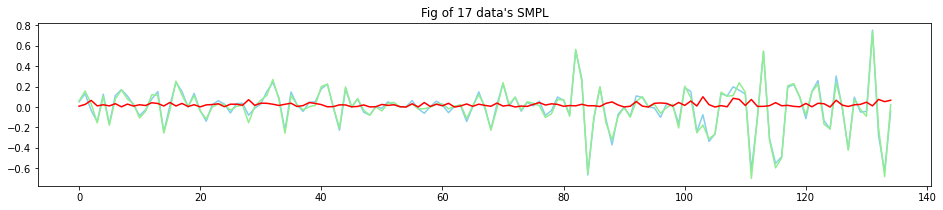

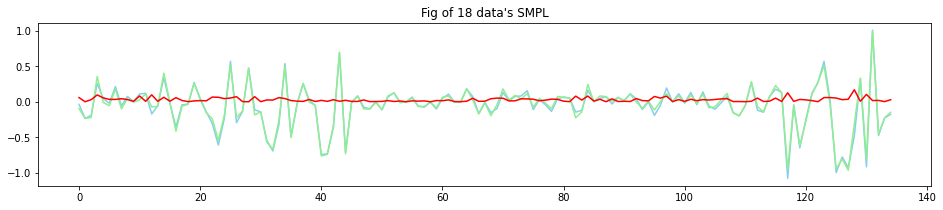

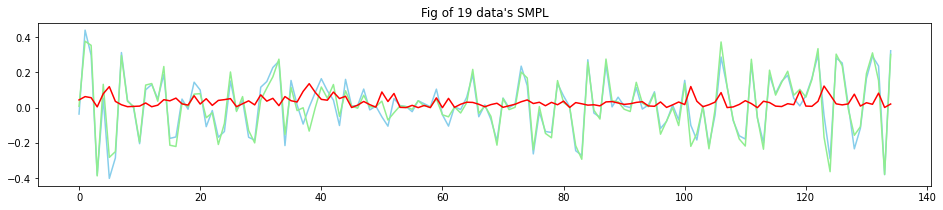

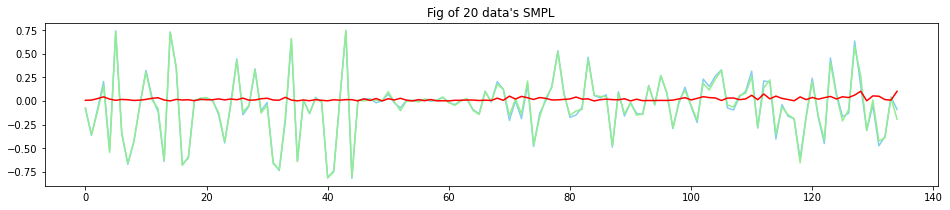

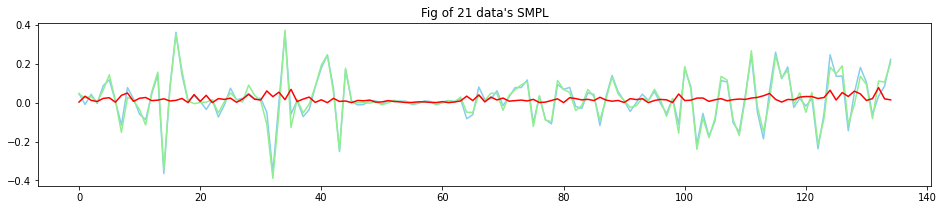

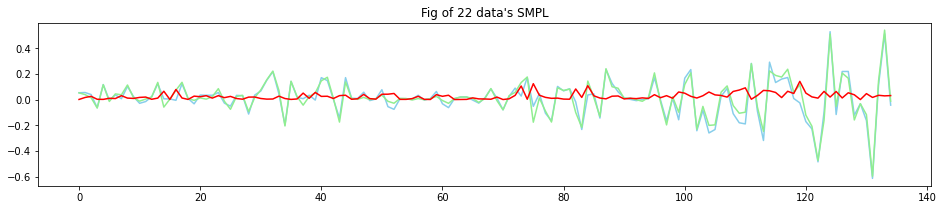

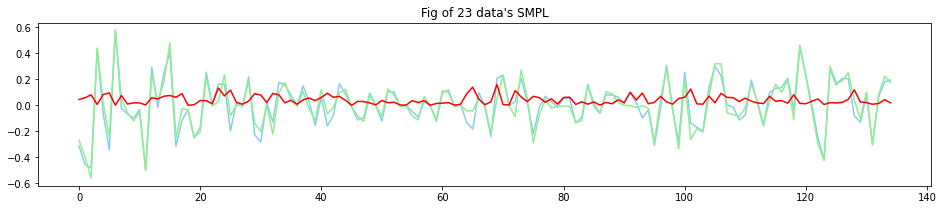

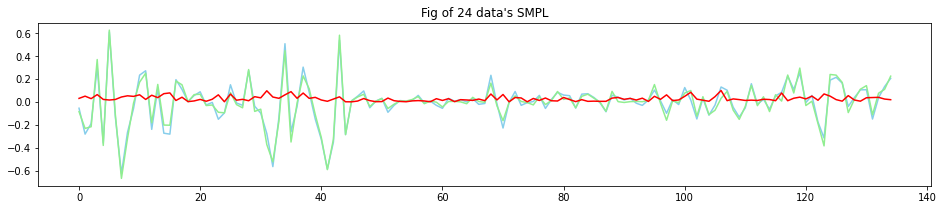

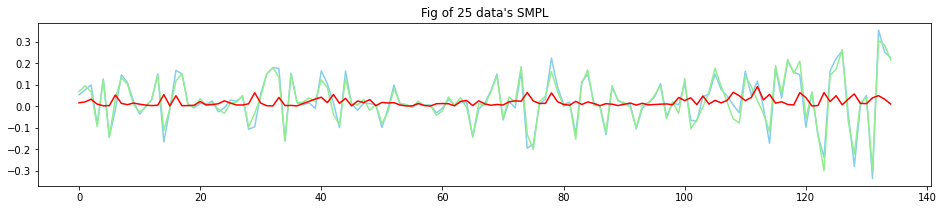

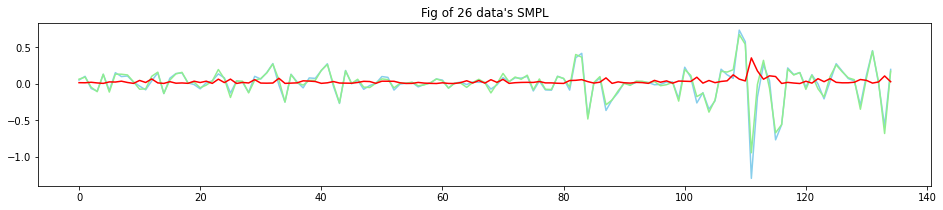

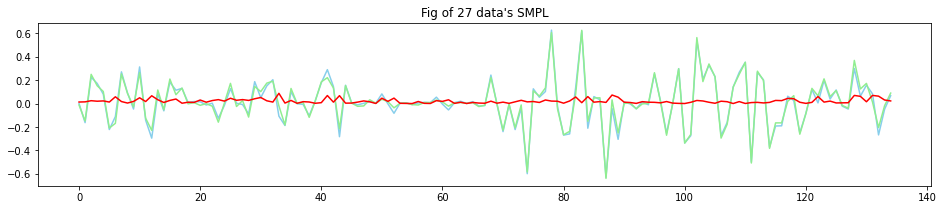

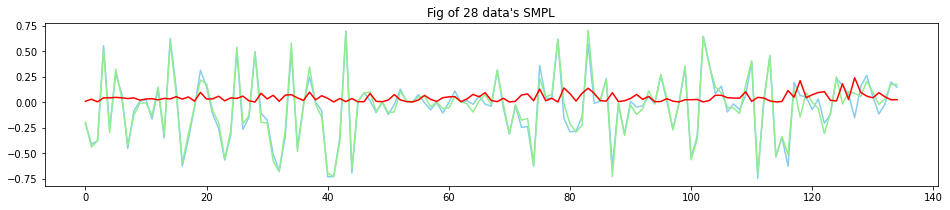

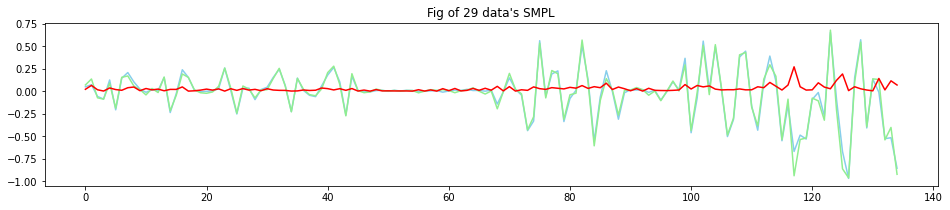

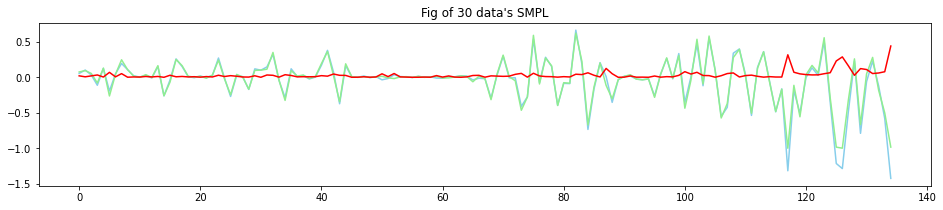

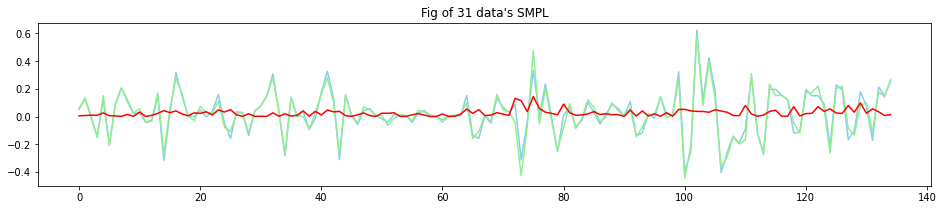

In [13]:
for idx in range(y.shape[0]):

    true_y = y.tolist()[idx]
    pred_y = _y.numpy().tolist()[idx]
    dif = np.abs(y- _y.numpy()).tolist()[idx]

    plt.figure(num = idx,figsize=[16,3])
    plt.title("Fig of "+str(idx)+" data's SMPL")
    plt.plot(spml_index,true_y,color="skyblue")
    plt.plot(spml_index,pred_y,color="lightgreen")
    plt.plot(spml_index,dif,color="red")
    plt.show()

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data).repeat(100)
# train_dataset_batch_selected = train_dataset.interleave(
#     lambda v: tf.data.Dataset.from_tensor_slices(scanner.random_fetch_arraylike(v)), # map_fn
#     cycle_length = 5, # cycle_length
#     block_length = 5, # block_length
# )